In [67]:
# importamos las librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


## 1. Exploración y preprocesamiento de datos:
  * Carga y explora el dataset, identificando las variables relacionadas con los datos sensoriales. Este conjunto de datos incluye lecturas de aceleración en los ejes X, Y y Z mientras los sujetos realizan actividades como caminar, correr, y subir escaleras.
  * Asegúrate de manejar cualquier valor nulo, normalizando las lecturas sensoriales para mejorar el rendimiento del análisis y el modelado posterior.

In [2]:
# cargamos el dataset
ruta= '../data/train.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(7352, 563)

In [3]:
# verificar si hay columnas que tienen valores nulos
df_isnull = df.isnull().sum()
columnas_nulas = df_isnull[df_isnull > 0]
columnas_nulas


Series([], dtype: int64)

No se visualizan valores nulos en el dataset

In [4]:
df.columns # mostramos las columnas de dataset

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [5]:
# creamos un objeto 'scaler' para estandarizar los datos
scaler = StandardScaler()
# seleccionamos las columnas correspondientes a los sensores (excluyendo 'subject' y 'Activity')
sensor_columns = df.columns[:-2]  # las últimas columnas son 'subject' y 'Activity'
# aplicamos la estandarización a las columnas de los sensores
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])
# mostramos un resumen estadístico de los datos después de la estandarización
print(df.describe())

       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count       7.352000e+03       7.352000e+03       7.352000e+03   
mean       -3.131336e-16       4.783986e-17       8.698156e-17   
std         1.000068e+00       1.000068e+00       1.000068e+00   
min        -1.814049e+01      -2.407152e+01      -1.573085e+01   
25%        -1.638693e-01      -1.756427e-01      -2.092798e-01   
50%         3.850502e-02       1.167141e-02       8.206943e-03   
75%         1.988854e-01       1.693906e-01       2.003738e-01   
max         1.032661e+01       2.493878e+01       1.958529e+01   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count      7.352000e+03       7352.000000      7.352000e+03      7.352000e+03   
mean      -1.507680e-16          0.000000      2.938044e-16      3.865847e-17   
std        1.000068e+00          1.000068      1.000068e+00      1.000068e+00   
min       -8.793362e-01         -0.972792     -9.440787e-01     -8.713436e-01   


## 2. Análisis no supervisado:
* Selecciona un enfoque de análisis no supervisado: K-means o PCA.
    * K-means: Utiliza K-means para agrupar las actividades de los usuarios en clusters y analiza si los grupos corresponden a los tipos de actividad física.
    * PCA: Si eliges PCA, realiza una reducción de dimensionalidad para identificar los componentes principales que explican la mayor variabilidad en los datos sensoriales. Visualiza los datos en el espacio reducido de los componentes principales.

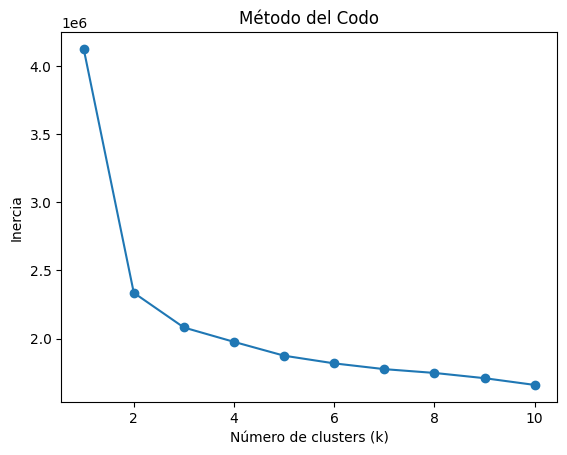

In [72]:
# inicializamos una lista vacía para almacenar los valores de inercia
inertia = []
# iteramos sobre diferentes valores de k (de 1 a 10)
for k in range(1, 11):
    # creamos un modelo KMeans con k clusters y un valor fijo para la aleatoriedad
    kmeans = KMeans(n_clusters=k, random_state=42)
    # ajustamos el modelo KMeans a los datos (sensor_columns) para encontrar los clusters
    kmeans.fit(df[sensor_columns])
    # agregamos la inercia (suma de distancias cuadradas de los puntos a sus centroides) a la lista inertia
    inertia.append(kmeans.inertia_)

# creamos un gráfico de línea para visualizar la inercia en función del número de clusters
plt.plot(range(1, 11), inertia, marker='o')
# añadimos etiquetas a los ejes
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
# añadimos un título al gráfico
plt.title('Método del Codo')
# mostramos el gráfico
plt.show()


* El modelo de K-means se ajusta mejor a los datos cuando k aumenta, 6 parece ser el más adecuado, pero debido a la complejidad y variabilidad de los datos, la reducción en la inercia no se estabiliza completamente.
* segun gpt: Esto es común cuando los datos son diversos y contienen patrones más complejos que no pueden ser completamente capturados con un número fijo de clusters.

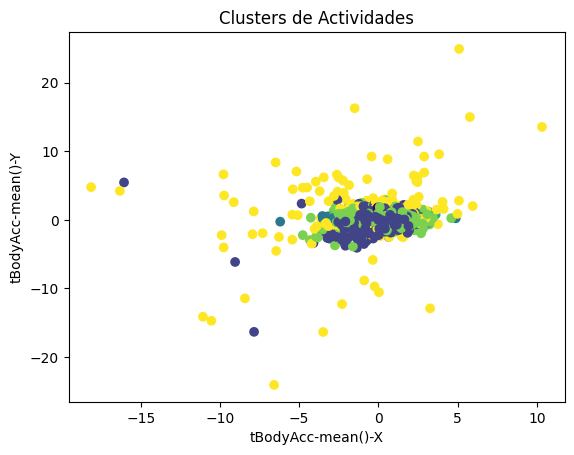

In [71]:
# definimos el número óptimo de clusters en 6
optimal_k = 6
# creamos el modelo de KMeans con 6 clusters y un valor fijo para la aleatoriedad
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# aplicamos KMeans al conjunto de datos y asignamos los resultados a la columna 'Cluster'
df['Cluster'] = kmeans.fit_predict(df[sensor_columns])
# generamos un gráfico de dispersión usando las características 'tBodyAcc-mean()-X' y 'tBodyAcc-mean()-Y',
plt.scatter(df['tBodyAcc-mean()-X'], df['tBodyAcc-mean()-Y'], c=df['Cluster'])
# añadimos etiquetas a los ejes X e Y para las características seleccionadas
plt.xlabel('tBodyAcc-mean()-X')
plt.ylabel('tBodyAcc-mean()-Y')
# establecemos el título del gráfico
plt.title('Clusters de Actividades')
# mostramos el gráfico
plt.show()


*  se puede observar que algunos de los clusters tienen carateristicas más heterogéneas que otras.

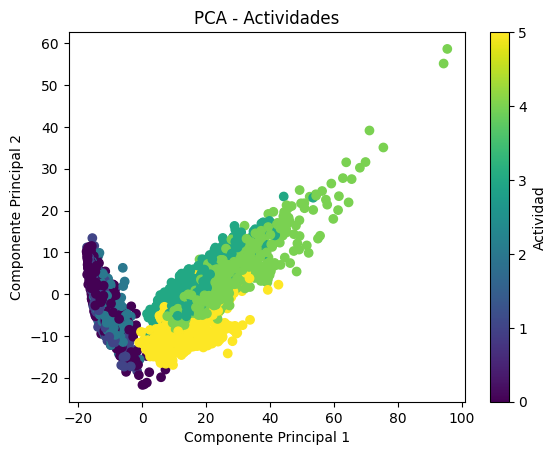

In [70]:
# aplicamos LabelEncoder para convertir las etiquetas de 'Activity' en valores numéricos
le = LabelEncoder()
df['Activity_encoded'] = le.fit_transform(df['Activity'])
# aplicamos PCA con 2 componentes principales para reducir la dimensionalidad de los datos
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[sensor_columns])
# creamos un DataFrame con los dos primeros componentes principales
data_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# generamos un gráfico de dispersión usando los dos primeros componentes principales,
plt.scatter(data_pca['PC1'], data_pca['PC2'], c=df['Activity_encoded'], cmap='viridis')
# añadimos etiquetas a los ejes X e Y para los dos componentes principales
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
# establecemos el título del gráfico
plt.title('PCA - Actividades')
# añadimos una barra de colores que indica las actividades codificadas de los puntos
plt.colorbar(label='Actividad')
# mostramos el gráfico
plt.show()

* En el grafico se observa que las actividades se agrupan pero estan mezcladas en algunos sectores, esto puede deberse a la superposicion de actividades similares.

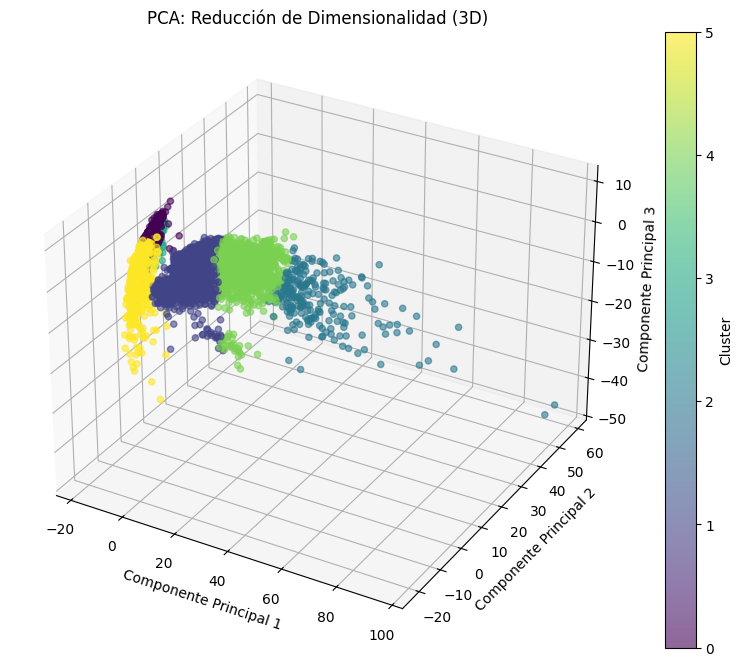

In [69]:
# aplicamos PCA con 3 componentes principales para reducir la dimensionalidad de los datos
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(df[sensor_columns])
# creamos un DataFrame con los tres primeros componentes principales
data_pca_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
# creamos una figura para el gráfico 3D con un tamaño de 10x8
fig = plt.figure(figsize=(10, 8))
# añadimos un subplot 3D a la figura
ax = fig.add_subplot(111, projection='3d')
# creamos un gráfico de dispersión 3D donde las coordenadas de los puntos son los tres componentes principales
scatter = ax.scatter(data_pca_3d['PC1'], data_pca_3d['PC2'], data_pca_3d['PC3'], c=df['Cluster'], cmap='viridis', alpha=0.6)
# añadimos etiquetas a los ejes X, Y y Z para los tres componentes principales
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
# establecemos el título del gráfico
ax.set_title('PCA: Reducción de Dimensionalidad (3D)')
# añadimos una barra de colores que indica el cluster correspondiente a cada punto
fig.colorbar(scatter, label='Cluster')
# mostramos el gráfico
plt.show()


*  En el grafico 3D con 3 componentes podemos observar lo mismo que en el grafico anterior, las actividades se agrupan pero estan mezcladas en algunos sectores, esto indica que hay superposicion de actividades similares.

## 3. Modelado con MLP:
* Desarrolla un modelo MLP para predecir el tipo de actividad física realizada por los usuarios basándose en los datos sensoriales.
  * Divide el dataset en conjuntos de entrenamiento y prueba, asegurándote de que las distintas actividades estén bien representadas en ambos conjuntos.
  * Configura la arquitectura del MLP, utilizando al menos dos capas ocultas, y ajusta hiperparámetros como el tamaño del batch, el número de épocas y la tasa de aprendizaje.

In [65]:
# codificamos las etiquetas de 'Activity' de manera numérica
le = LabelEncoder()
y = le.fit_transform(df['Activity'])
# normalizamos los datos de las columnas de los sensores para que todos tengan la misma escala
scaler = StandardScaler()
X = scaler.fit_transform(df[sensor_columns])
# dividimos los datos en dos conjuntos: uno para entrenar el modelo y otro para probarlo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# creamos un modelo secuencial vacío, al que vamos a añadir capas
model = Sequential()
# añadimos la primera capa densa (fully connected) con 128 neuronas y activación ReLU
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# añadimos una segunda capa densa con 64 neuronas y activación ReLU
model.add(Dense(64, activation='relu'))
# añadimos la capa de salida con un número de neuronas igual al número de clases en 'Activity'
# la activación 'softmax' asegura que la salida será una distribución de probabilidades
model.add(Dense(len(np.unique(y)), activation='softmax'))  # número de clases en 'Activity'
# compilamos el modelo, especificando la función de pérdida, el optimizador y las métricas a evaluar
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# entrenamos el modelo con los datos de entrenamiento, usando un 20% para validación, durante 50 épocas
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50


/home/cvelazquez/anaconda3/envs/ds_mitic/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7812 - loss: 0.5439 - val_accuracy: 0.9507 - val_loss: 0.1371
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9635 - loss: 0.0988 - val_accuracy: 0.9643 - val_loss: 0.0932
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9748 - loss: 0.0673 - val_accuracy: 0.9592 - val_loss: 0.1025
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9826 - loss: 0.0491 - val_accuracy: 0.9686 - val_loss: 0.0851
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0444 - val_accuracy: 0.9830 - val_loss: 0.0496
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9862 - loss: 0.0366 - val_accuracy: 0.9796 - val_loss: 0.0474
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9868 - loss: 0.0385 - val_accuracy: 0.9592 - val_loss: 0.0988
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9849 - loss: 0.0393 - val_accuracy: 0.9813 - val_

## 4. Evaluación del modelo:
  * Evalúa el rendimiento del MLP utilizando métricas como la precisión, el recall, el F1-score y la matriz de confusión. Discute si el modelo es capaz de predecir correctamente las distintas actividades físicas.
  * Visualiza las curvas de aprendizaje, mostrando cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento.

In [74]:
# usamos el modelo entrenado para hacer predicciones sobre el conjunto de prueba (X_test)
y_pred = model.predict(X_test)
# obtenemos la clase predicha para cada muestra, tomando el índice con la mayor probabilidad
y_pred_classes = y_pred.argmax(axis=1)
# imprimimos el reporte de clasificación, que muestra varias métricas de evaluación
print(classification_report(y_test, y_pred_classes))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       0.97      0.96      0.97       257
           2       0.97      0.97      0.97       275
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       197
           5       1.00      1.00      1.00       215

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



* De acuerdo a los resultado, el modelo está identificando correctamente las actividades en casi todos los casos, en general tiene un desempeño bastante bueno, con una tasa de acierto del 99%.

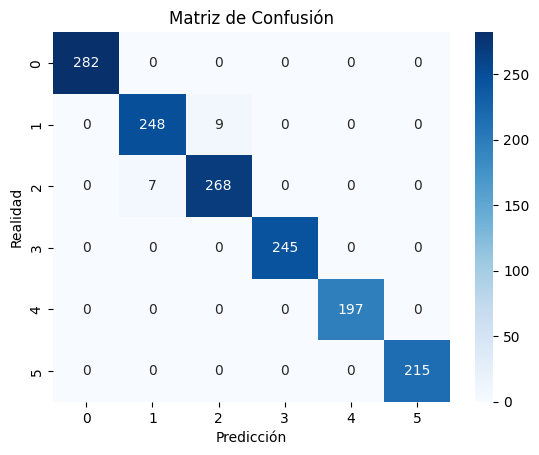

In [75]:
# calculamos la matriz de confusión comparando las etiquetas reales (y_test) con las predicciones (y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# usamos un mapa de calor (heatmap) para visualizar la matriz de confusión, con los valores numéricos anotados en cada celda
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# configuramos las etiquetas del eje X (Predicción) y el eje Y (Realidad) para la gráfica
plt.xlabel('Predicción')
plt.ylabel('Realidad')
# le damos un título a la gráfica
plt.title('Matriz de Confusión')
# mostramos la gráfica generada
plt.show()

* El modelo tiene un rendimiento muy bueno, con la mayoría de las instancias correctamente clasificadas, los errores son muy pequeños y probablemente no afecten significativamente el rendimiento global del modelo.

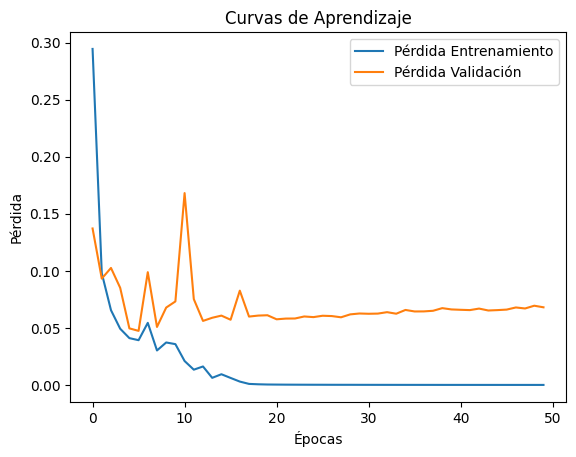

In [76]:
# trazamos la curva de la pérdida durante el entrenamiento usando los valores de 'loss' registrados en el historial de entrenamiento
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
# trazamos la curva de la pérdida en el conjunto de validación usando los valores de 'val_loss' registrados en el historial de validación
plt.plot(history.history['val_loss'], label='Pérdida Validación')
# le damos un título a la gráfica para describirla
plt.title('Curvas de Aprendizaje')
# configuramos la etiqueta del eje X para mostrar el número de épocas
plt.xlabel('Épocas')
# configuramos la etiqueta del eje Y para mostrar el valor de la pérdida
plt.ylabel('Pérdida')
# agregamos una leyenda para identificar las curvas de entrenamiento y validación
plt.legend()
# mostramos la gráfica generada
plt.show()

* La pérdida disminuye constantemente a lo largo del entrenamiento, lo que indica que el modelo está mejorando sus predicciones. Sin embargo, al final la tasa de mejora es mucho más pequeña, lo que es típico cuando el modelo se acerca a su capacidad de generalización máxima.
* En las épocas intermedias, hay algunas fluctuaciones, lo cual puede ser signo de que el modelo está ajustándose a los datos de validación.
* Hacia el final, la pérdida de validación se estabiliza, lo que indica que el modelo ya no está mejorando.

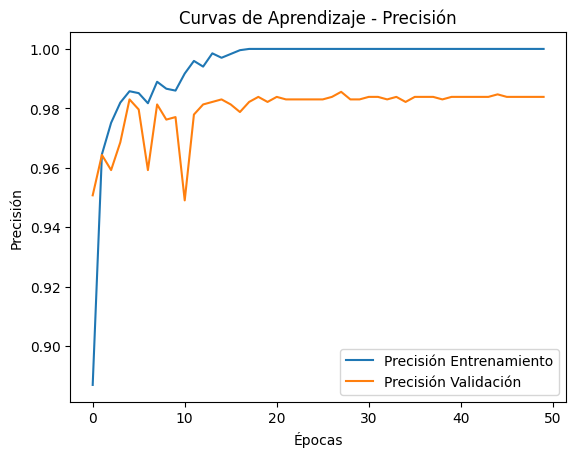

In [81]:
# trazamos la curva de la precisión durante el entrenamiento usando los valores de 'accuracy' registrados en el historial de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
# trazamos la curva de la precisión en el conjunto de validación usando los valores de 'val_accuracy' registrados en el historial de validación
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
# le damos un título a la gráfica para describirla
plt.title('Curvas de Aprendizaje - Precisión')
# configuramos la etiqueta del eje X para mostrar el número de épocas
plt.xlabel('Épocas')
# configuramos la etiqueta del eje Y para mostrar el valor de la precisión
plt.ylabel('Precisión')
# agregamos una leyenda para identificar las curvas de entrenamiento y validación
plt.legend()
# mostramos la gráfica generada
plt.show()

* La precisión comienza a aumentar desde alrededor de 88% y mejora con el tiempo, aumenta rápidamente en las primeras épocas y se acerca al 100%, se estabiliza en 1.0, lo que indica que el modelo está logrando predicciones muy buenas en los datos de entrenamiento.
* La precisión de validación comienza alta y sigue mejorando, se estabiliza alrededor de 98% durante las últimas épocas.
* Podemos decir que el modelo está aprendiendo patrones útiles.


## 5. Discusión y análisis:
  * Reflexiona sobre los resultados del análisis no supervisado. ¿El análisis de clusters o PCA proporcionó insights útiles sobre las actividades? ¿Qué características son más importantes para clasificar las actividades físicas?
  * Discute el rendimiento del MLP y cómo podría mejorarse. ¿Es adecuado este enfoque para predecir actividades basadas en datos sensoriales?

* La pérdida de entrenamiento comienza relativamente alta y disminuye de forma constante a lo largo de las épocas, alcanzando valores cercanos a 0 al final. Esto indica que el modelo está mejorando en la minimización del error durante el entrenamiento.
* La pérdida de validación sigue un patrón similar, pero de manera más estable, alcanzando valores muy pequeños al final. Aunque la pérdida de validación es algo mayor que la de entrenamiento, sigue siendo baja, lo que sugiere que el modelo generaliza bien en los datos de validación.
* La precisión de entrenamiento comienza alrededor del 88% y aumenta rápidamente, alcanzando 100% al final del entrenamiento. Esto significa que el modelo está aprendiendo muy bien los datos de entrenamiento y alcanza un rendimiento perfecto en ese conjunto.
* La precisión de validación comienza alrededor de 95% y también mejora de manera estable, alcanzando aproximadamente 98% al final. Aunque no llega al 100% como en el entrenamiento, se mantiene alta y estable, lo que indica que el modelo no está sobreajustando y generaliza bien a los datos no vistos.
* El modelo está aprendiendo bien: Las pérdidas de entrenamiento y validación bajan de manera consistente, y las precisiones aumentan significativamente en ambos conjuntos.
* La precisión de validación es alta y estable, lo que muestra que el modelo no solo se ajusta bien a los datos de entrenamiento, sino que también realiza buenas predicciones en datos nuevos.
* Aunque la precisión de entrenamiento llega al 100%, la diferencia con la precisión de validación es pequeña, lo que indica que el modelo no está sobreajustando.

* Podriamos decir que el modelo aplicado es el ideal para el caso de estudio.